100%|██████████| 9.91M/9.91M [00:10<00:00, 903kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 56.6kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.47MB/s]


Client 5 Round 1 - Reputation: 0.75
Client 4 Round 1 - Reputation: 0.75
Client 8 Round 1 - Reputation: 0.75
Client 9 Round 1 - Reputation: 0.75
Client 6 Round 1 - Reputation: 0.75
Client 2 Round 1 - Reputation: 0.75
Client 0 Round 1 - Reputation: 0.75
Client 3 Round 1 - Reputation: 0.75
Client 7 Round 1 - Reputation: 0.75
Client 1 Round 1 - Reputation: 0.75
Client 5 Round 2 - Reputation: 0.80
Client 4 Round 2 - Reputation: 0.80
Client 8 Round 2 - Reputation: 0.80
Client 6 Round 2 - Reputation: 0.80
Client 9 Round 2 - Reputation: 0.80
Client 2 Round 2 - Reputation: 0.80
Client 0 Round 2 - Reputation: 0.80
Client 3 Round 2 - Reputation: 0.80
Client 7 Round 2 - Reputation: 0.80
Client 1 Round 2 - Reputation: 0.80
Client 5 Round 3 - Reputation: 0.85
Client 4 Round 3 - Reputation: 0.85
Client 8 Round 3 - Reputation: 0.85
Client 6 Round 3 - Reputation: 0.85
Client 9 Round 3 - Reputation: 0.85
Client 0 Round 3 - Reputation: 0.85
Client 2 Round 3 - Reputation: 0.85
Client 3 Round 3 - Reputatio

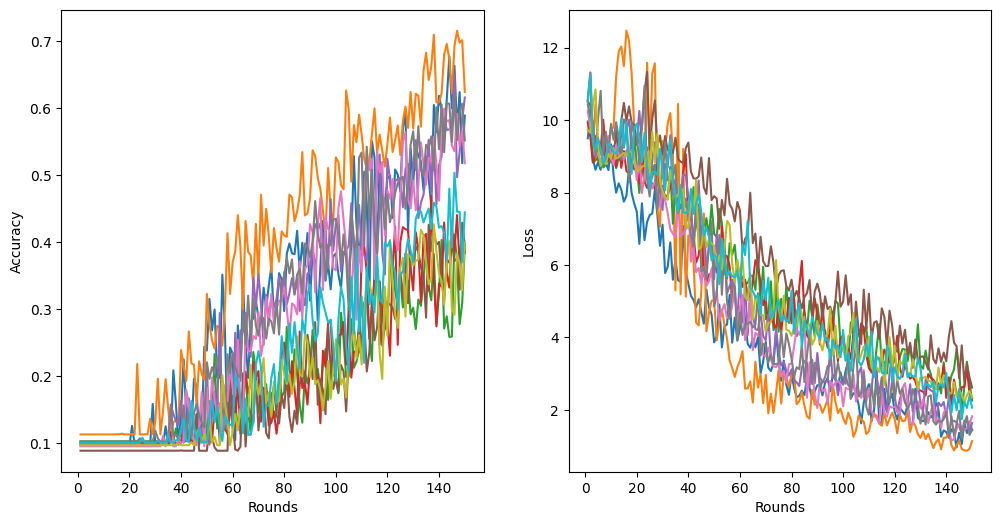

In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import threading
import random
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
random.seed(42)
numpy_rng = np.random.default_rng(42)

def split_dataset_label_skew(dataset, num_clients=10, num_classes=10):
    assert num_clients == num_classes, "For one class per client, num_clients must equal num_classes."
    indices_by_class = {i: [] for i in range(num_classes)}
    for idx, (_, label) in enumerate(dataset):
        indices_by_class[label].append(idx)
    for label in indices_by_class:
        numpy_rng.shuffle(indices_by_class[label])
    clients_indices = [indices_by_class[i] for i in range(num_clients)]
    return [Subset(dataset, indices) for indices in clients_indices]

class SCAFFOLDNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(128 * 14 * 14, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        return self.fc(x)

class Client:
    def __init__(self, client_id, dataset, shared_memory, timestamps, neighbor_dict, c_local, c_global):
        self.client_id = client_id
        self.dataset = dataset
        self.shared_memory = shared_memory
        self.timestamps = timestamps
        self.neighbor_dict = neighbor_dict
        self.c_local = c_local
        self.c_global = c_global
        self.history = []
        self.memory_lock = threading.Lock()
        self.reputation = 0.7

    def update_reputation(self, prev_loss, new_loss):
        if new_loss < prev_loss:
            self.reputation = min(1.0, self.reputation + 0.05)
        else:
            self.reputation = max(0.0, self.reputation - 0.1)
        return self.reputation

    def train(self, parameters, lr):
        net = SCAFFOLDNet().to(device)
        net.load_state_dict(parameters)
        optimizer = optim.SGD(net.parameters(), lr=lr)
        dataloader = DataLoader(self.dataset, batch_size=64, shuffle=True)
        prev_loss = float('inf')
        for _ in range(3):
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = net(images)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
        accuracy, new_loss = self.get_metrics(net)
        self.update_reputation(prev_loss, new_loss)
        return net.state_dict()

    def get_metrics(self, net):
        dataloader = DataLoader(dev_dataset, batch_size=64)
        correct, total = 0, 0
        total_loss = 0.0
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = F.cross_entropy(outputs, labels, reduction='sum')
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        avg_loss = total_loss / total
        self.history.append((accuracy, avg_loss))
        return accuracy, avg_loss

num_clients = 10
train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_dataset, dev_dataset = split_dataset_label_skew(train_dataset, num_clients), test_dataset

shared_memory = {}
timestamps = {i: 0 for i in range(num_clients)}
neighbor_dict = {i: [] for i in range(num_clients)}
c_global = {name: torch.zeros_like(param) for name, param in SCAFFOLDNet().state_dict().items()}
clients = [Client(i, train_dataset[i], shared_memory, timestamps, neighbor_dict, c_global.copy(), c_global) for i in range(num_clients)]

def train_asynchronously(client_id, client, max_rounds, base_lr):
    lr = base_lr
    for round_num in range(max_rounds):
        if client.reputation < 0.3:
            print(f"Client {client_id} removed due to low reputation ({client.reputation:.2f})")
            return
        neighbors = random.sample(range(num_clients), random.randint(1, num_clients - 1))
        client.neighbor_dict[client_id] = neighbors
        available_params = [client.shared_memory[neighbor] for neighbor in neighbors if neighbor in client.shared_memory]
        aggregated_params = SCAFFOLDNet().state_dict() if not available_params else available_params[0]
        updated_params = client.train(aggregated_params, lr)
        client.shared_memory[client_id] = updated_params
        print(f"Client {client_id} Round {round_num + 1} - Reputation: {client.reputation:.2f}")
        if (round_num + 1) % 5 == 0:
            lr *= 0.9

threads = [threading.Thread(target=train_asynchronously, args=(i, client, 150, 0.02)) for i, client in enumerate(clients)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

def plot_combined_metrics(clients):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for client in clients:
        plt.plot(range(1, len(client.history) + 1), [entry[0] for entry in client.history])
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.subplot(1, 2, 2)
    for client in clients:
        plt.plot(range(1, len(client.history) + 1), [entry[1] for entry in client.history])
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.show()

plot_combined_metrics(clients)
